# Naudojamos bibliotekos:

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [9]:
failo_kelias = r"C:\Users\Paulius\Duomenu mokslas\projektas_US_rinkimai\1976-2020-senate.csv"
senato_duomenys = pd.read_csv(failo_kelias)

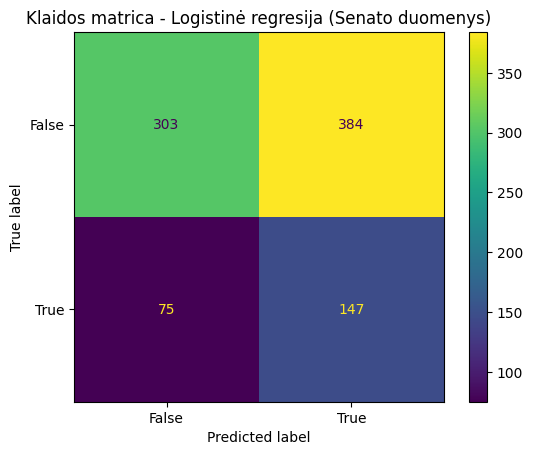

Tikslumas: 0.49504950495049505
ROC AUC: 0.590549064348191
Klasifikacijos ataskaita:
               precision    recall  f1-score   support

       False       0.80      0.44      0.57       687
        True       0.28      0.66      0.39       222

    accuracy                           0.50       909
   macro avg       0.54      0.55      0.48       909
weighted avg       0.67      0.50      0.53       909



In [10]:
# Valyti duomenis ir pasirinkti reikalingas savybes
isvalyti_duomenys = senato_duomenys[["year", "state_fips", "party_detailed", "totalvotes", "laimetojas"]].dropna()

# Užkoduoti kategorinius duomenis
encoder = LabelEncoder()
isvalyti_duomenys["party_detailed"] = encoder.fit_transform(isvalyti_duomenys["party_detailed"])

# Paruošti savybes (X) ir tikslą (y)
savybes = isvalyti_duomenys[["year", "state_fips", "party_detailed", "totalvotes"]]
tikslas = isvalyti_duomenys["laimetojas"]

# Padalinti duomenis į mokymo ir testavimo rinkinius
mokymo_duomenys, testavimo_duomenys, mokymo_tikslas, testavimo_tikslas = train_test_split(
    savybes, tikslas, test_size=0.3, random_state=42
)

# Logistinės regresijos modelis su subalansuotomis klasėmis
log_reg_modelis = LogisticRegression(class_weight="balanced", random_state=42, max_iter=500)
log_reg_modelis.fit(mokymo_duomenys, mokymo_tikslas)

# Prognozės ir vertinimo metrikos
prognozes = log_reg_modelis.predict(testavimo_duomenys)
tikslumas = accuracy_score(testavimo_tikslas, prognozes)
roc_auc = roc_auc_score(testavimo_tikslas, log_reg_modelis.predict_proba(testavimo_duomenys)[:, 1])
klasifikacijos_ataskaita = classification_report(testavimo_tikslas, prognozes)

# Klaidos matricos atvaizdavimas
ConfusionMatrixDisplay.from_estimator(log_reg_modelis, testavimo_duomenys, testavimo_tikslas)
plt.title("Klaidos matrica - Logistinė regresija (Senato duomenys)")
plt.show()

# Spausdinti metrikas
print("Tikslumas:", tikslumas)
print("ROC AUC:", roc_auc)
print("Klasifikacijos ataskaita:\n", klasifikacijos_ataskaita)


Analizė 

Tikslumas (Accuracy) 49.5%
Modelio prognozės teisingos tik maždaug pusę laiko, o tai nėra geras rezultatas. Atsižvelgiant į tai, kad tikslumo rodiklis yra beveik lygus atsitiktiniam spėjimui (50%), modelis šiuo metu neturi didelės prognozavimo galios.

ROC AUC: 0.59
ROC AUC matuoja modelio gebėjimą atskirti klases („True“ ir „False“). Vertė 0.59 rodo, kad modelio atskyrimo gebėjimas yra šiek tiek geresnis nei atsitiktinis (0.5). Tai rodo, kad modelis turi potencialą, tačiau reikia daugiau darbo savybių ar modelio parametrų derinimo.

False (Netiesa):
Tikslumas (Precision): 80%: Kai modelis prognozuoja „False“, jis yra gana tikslus. Tai reiškia, kad dauguma atvejų, kai modelis prognozuoja „False“, prognozė yra teisinga.

Aptikimo dažnis (Recall): 44%: Tik 44% tikrųjų „False“ atvejų modelis teisingai identifikuoja kaip „False“.

F1-rezultatas: 57%: Subalansuotas matas tarp tikslumo ir aptikimo dažnio rodo, kad šios klasės identifikavimas yra vidutinis.

True (Tiesa):
Tikslumas (Precision): 28%: Kai modelis prognozuoja „True“, jis yra netikslus. Daugeliu atvejų modelis priskiria „True“ netinkamoms eilutėms.

Aptikimo dažnis (Recall): 66%: Tačiau modelis sugeba gerai identifikuoti „True“ atvejus, nes atpažįsta apie 66% tikrųjų „True“ atvejų.

F1-rezultatas: 39%: Šioje klasėje subalansuotas rezultatas yra prastas, nes tikslumas ir aptikimo dažnis labai skiriasi.

Klaidos matrica:
Klaidos matrica parodo, kaip tiksliai modelis prognozuoja kiekvieną klasę:

303 (Teisingai „False“): Modelis teisingai identifikavo 303 atvejus kaip „False“.

147 (Teisingai „True“): Modelis teisingai identifikavo 147 atvejus kaip „True“.

384 (Klaidingai „True“): Modelis klaidingai priskyrė 384 atvejus kaip „True“, kai jie turėjo būti „False“.

75 (Klaidingai „False“): Modelis klaidingai priskyrė 75 atvejus kaip „False“, kai jie turėjo būti „True“.

Modelis dažnai klaidingai priskiria „False“ atvejus kaip „True“ (384 klaidingos prognozės).
Dėl to tikslumas mažėja, ypač kai reikia prognozuoti „True“.

In [20]:
# Pasiruošiame duomenis prognozuoti „laimėtojas“
X_senate = senato_duomenys.drop(columns=["laimetojas", "candidatevotes"])  # Nepriklausomi kintamieji
y_laimejo = senato_duomenys["laimetojas"]  # Tikslinis kintamasis

# Kodavimas ir trūkstamų reikšmių tvarkymas
for col in X_senate.select_dtypes(include=["object"]).columns:
    X_senate[col] = LabelEncoder().fit_transform(X_senate[col].astype(str))
X_senate = X_senate.fillna(X_senate.mean())

# Duomenų padalijimas
X_train, X_test, y_train, y_test = train_test_split(X_senate, y_laimejo, test_size=0.2, random_state=42)

# Atsitiktinių miškų modelis
rf_laimejo = RandomForestClassifier(n_estimators=100, random_state=42)
rf_laimejo.fit(X_train, y_train)
y_pred_laimejo = rf_laimejo.predict(X_test)

# Rezultatai
print("Prognozė: Laimėtojas")
print(f"Tikslumas: {accuracy_score(y_test, y_pred_laimejo):.2f}")
print(classification_report(y_test, y_pred_laimejo))


Prognozė: Laimėtojas
Tikslumas: 0.98
              precision    recall  f1-score   support

       False       1.00      0.98      0.99       589
        True       0.94      0.99      0.96       137

    accuracy                           0.98       726
   macro avg       0.97      0.99      0.98       726
weighted avg       0.99      0.98      0.98       726



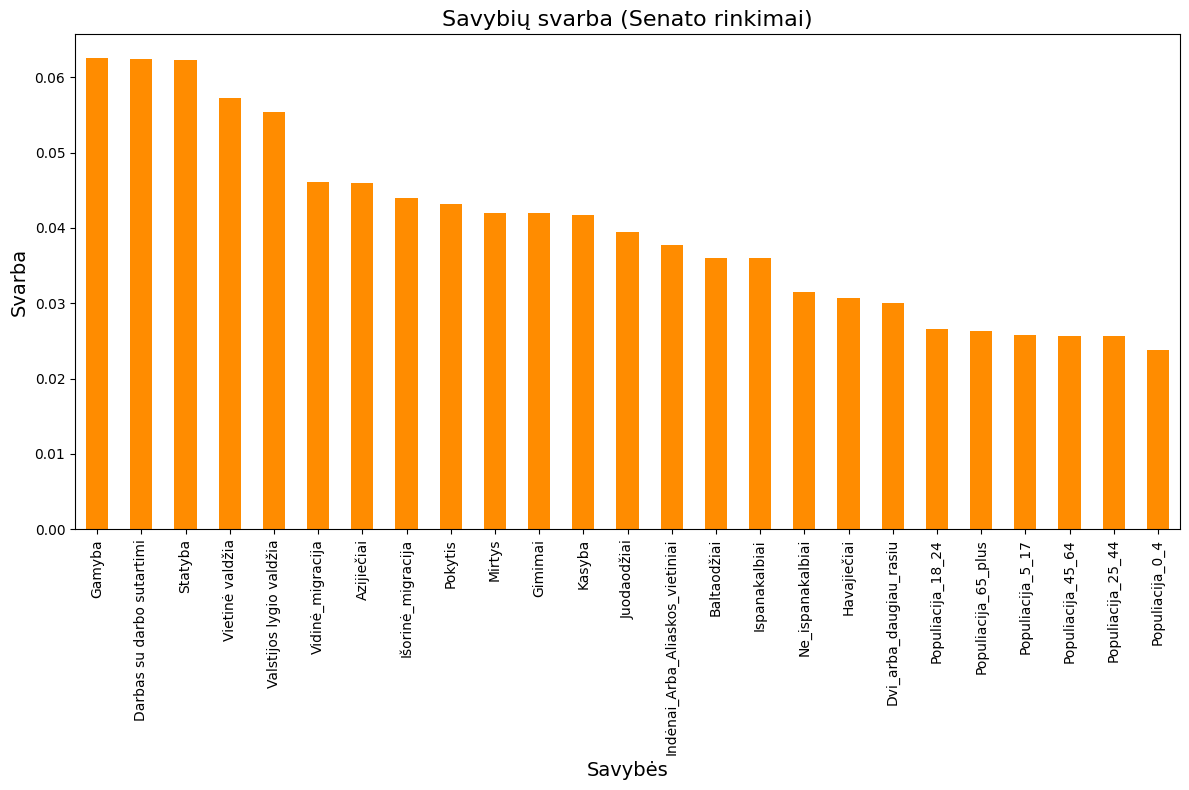

In [21]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Pasirenkame savybes ir tikslinį kintamąjį
naudotini_stulpeliai = [
    "Populiacija_0_4", "Populiacija_5_17", "Populiacija_18_24",
    "Populiacija_25_44", "Populiacija_45_64", "Populiacija_65_plus",
    "Baltaodžiai", "Juodaodžiai", "Indėnai_Arba_Aliaskos_vietiniai",
    "Azijiečiai", "Havajiečiai", "Dvi_arba_daugiau_rasiu",
    "Ne_ispanakalbiai", "Ispanakalbiai",
    "Darbas su darbo sutartimi", "Kasyba", "Statyba", "Gamyba",
    "Vidinė_migracija", "Išorinė_migracija", "Pokytis",
    "Gimimai", "Mirtys", "Valstijos lygio valdžia", "Vietinė valdžia"
]
# Pasirenkame savybes ir tikslinį kintamąjį
X = senato_duomenys[naudotini_stulpeliai]
y = senato_duomenys["laimetojas"]

# Užpildome trūkstamas reikšmes
X = X.fillna(X.mean())

# Duomenų padalijimas
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelio treniravimas
modelis = RandomForestClassifier(n_estimators=100, random_state=42)
modelis.fit(X_train, y_train)

# Savybių svarba
svarba = modelis.feature_importances_
svarbu_savybes = pd.Series(svarba, index=naudotini_stulpeliai).sort_values(ascending=False)

# Braižome svarbos grafą
plt.figure(figsize=(12, 8))
svarbu_savybes.plot(kind="bar", color="darkorange")
plt.title("Savybių svarba (Senato rinkimai)", fontsize=16)
plt.xlabel("Savybės", fontsize=14)
plt.ylabel("Svarba", fontsize=14)
plt.tight_layout()
plt.show()


In [22]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Pasiruošiame duomenis prognozuoti „kandidatų balsai“
X_senate_votes = senato_duomenys.drop(columns=["candidatevotes", "laimetojas"])  # Nepriklausomi kintamieji
y_balsai = senato_duomenys["candidatevotes"]  # Tikslinis kintamasis

# Kodavimas ir trūkstamų reikšmių tvarkymas
for col in X_senate_votes.select_dtypes(include=["object"]).columns:
    X_senate_votes[col] = LabelEncoder().fit_transform(X_senate_votes[col].astype(str))
X_senate_votes = X_senate_votes.fillna(X_senate_votes.mean())

# Duomenų padalijimas
X_train_votes, X_test_votes, y_train_votes, y_test_votes = train_test_split(X_senate_votes, y_balsai, test_size=0.2, random_state=42)

# Atsitiktinių miškų regresorius
rf_votes = RandomForestRegressor(n_estimators=100, random_state=42)
rf_votes.fit(X_train_votes, y_train_votes)
y_pred_votes = rf_votes.predict(X_test_votes)

# Rezultatai
mse = mean_squared_error(y_test_votes, y_pred_votes)
r2 = r2_score(y_test_votes, y_pred_votes)
print("Prognozė: Kandidatų balsai")
print(f"Vidutinis kvadratinis nuokrypis (MSE): {mse:.2f}")
print(f"R2 rezultatas: {r2:.2f}")


Prognozė: Kandidatų balsai
Vidutinis kvadratinis nuokrypis (MSE): 2347524034.80
R2 rezultatas: 0.99


In [26]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

# Load and preprocess the data
naudotini_stulpeliai = [
    "Populiacija_0_4", "Populiacija_5_17", "Populiacija_18_24",
    "Populiacija_25_44", "Populiacija_45_64", "Populiacija_65_plus",
    "Baltaodžiai", "Juodaodžiai", "Indėnai_Arba_Aliaskos_vietiniai",
    "Azijiečiai", "Havajiečiai", "Dvi_arba_daugiau_rasiu",
    "Ne_ispanakalbiai", "Ispanakalbiai",
    "Darbas su darbo sutartimi", "Kasyba", "Statyba", "Gamyba",
    "Vidinė_migracija", "Išorinė_migracija", "Pokytis",
    "Gimimai", "Mirtys", "Valstijos lygio valdžia", "Vietinė valdžia"
]
X = senato_duomenys[naudotini_stulpeliai]
y = senato_duomenys["laimetojas"]

# Encode the target variable
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
y = to_categorical(y)  # One-hot encoding

# Handle missing values (fill with mean)
X = X.fillna(X.mean())

# Normalize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Oversample the minority class using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, np.argmax(y, axis=1))
y_resampled = to_categorical(y_resampled)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Define the neural network model
model = Sequential([
    Dense(128, input_dim=X.shape[1], activation="relu"),  # First layer
    Dropout(0.3),                                        # Dropout for regularization
    Dense(64, activation="relu"),                        # Second layer
    Dropout(0.3),
    Dense(y.shape[1], activation="softmax")              # Output layer
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {accuracy:.2f}")

# Predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes))

Epoch 1/100


c:\Users\Paulius\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5299 - loss: 0.7197 - val_accuracy: 0.5777 - val_loss: 0.6815
Epoch 2/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step - accuracy: 0.5533 - loss: 0.6902 - val_accuracy: 0.5635 - val_loss: 0.6787
Epoch 3/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step - accuracy: 0.5653 - loss: 0.6910 - val_accuracy: 0.5985 - val_loss: 0.6762
Epoch 4/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step - accuracy: 0.5728 - loss: 0.6847 - val_accuracy: 0.5985 - val_loss: 0.6748
Epoch 5/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step - accuracy: 0.5501 - loss: 0.6826 - val_accuracy: 0.5886 - val_loss: 0.6748
Epoch 6/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step - accuracy: 0.5771 - loss: 0.6784 - val_accuracy: 0.5908 - val_loss: 0.6742
Epoch 7/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step - accuracy: 0.5774 - loss: 0.6756 - val_accuracy: 0.6018 - val_loss: 0.6717
Epoch 8/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step - accuracy: 0.5755 - loss: 0.6786 - val_ac


Tikslumas – 59%:
Modelis teisingai klasifikavo 59% pavyzdžių. Rezultatas yra vidutinis.

Tikslumas („precision“):
Klasė 0: 61% teisingų „Nelaimėjo“ spėjimų.
Klasė 1: 57% teisingų „Laimėjo“ spėjimų.

Jautrumas („recall“):
Klasė 0: 45% teisingai atpažintų „Nelaimėjo“.
Klasė 1: 72% teisingai atpažintų „Laimėjo“.

F1 rodiklis:

Klasė 0: 0.52, Klasė 1: 0.64. „Laimėjo“ klasė geriau klasifikuojama.

Optimizuoti hiperparametrus, kad būtų galima pasiekti geresnį tikslumą.

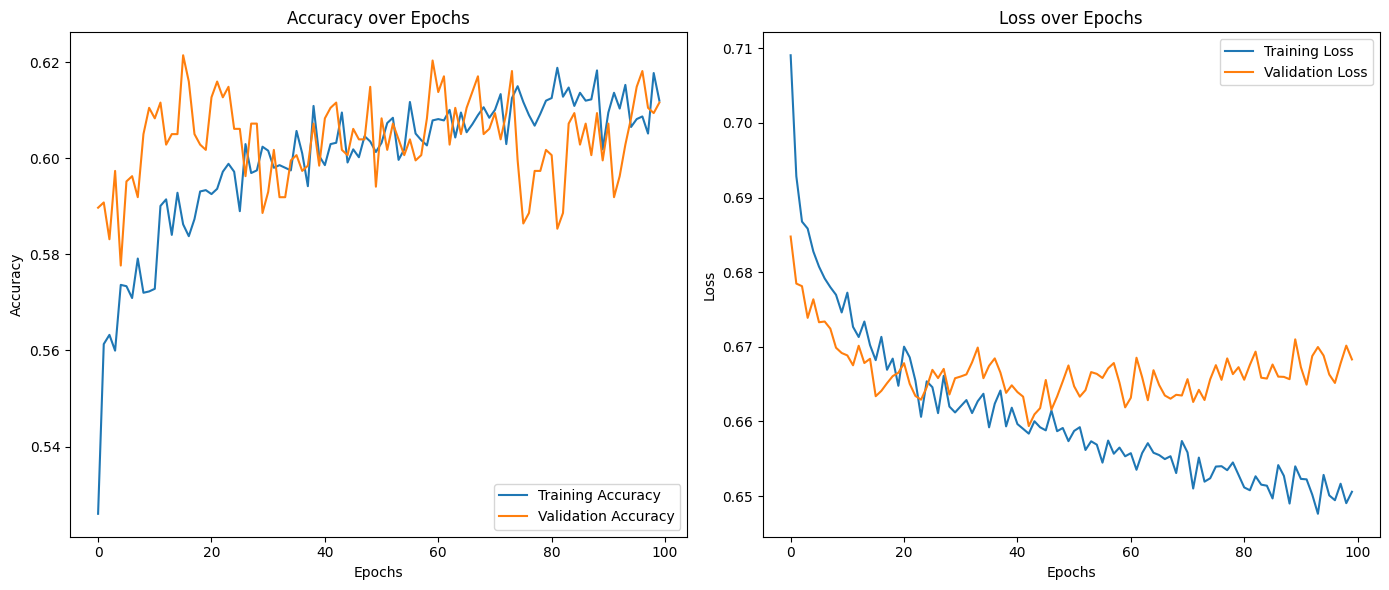

In [24]:
# Visualization of training history
plt.figure(figsize=(14, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy over Epochs")

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss over Epochs")

plt.tight_layout()
plt.show()

Treniravimo ir validavimo tikslumas stabilizuojasi ties ~60%, rodo gerą modelio mokymąsi be pertreniruoto požymių.

Treniravimo ir validavimo nuostolis mažėja, tačiau validavimo nuostolis pradeda svyruoti, artėjant prie optimalaus taško.

Modelis stabilus, tikslumas ~59%. Norint gerinti, galima didinti modelio sudėtingumą ar bandyti sudėtingesnius optimizatorius.

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

# Duomenų paruošimas
naudotini_stulpeliai = [
    "Populiacija_0_4", "Populiacija_5_17", "Populiacija_18_24",
    "Populiacija_25_44", "Populiacija_45_64", "Populiacija_65_plus",
    "Baltaodžiai", "Juodaodžiai", "Indėnai_Arba_Aliaskos_vietiniai",
    "Azijiečiai", "Havajiečiai", "Dvi_arba_daugiau_rasiu",
    "Ne_ispanakalbiai", "Ispanakalbiai",
    "Darbas su darbo sutartimi", "Kasyba", "Statyba", "Gamyba",
    "Vidinė_migracija", "Išorinė_migracija", "Pokytis",
    "Gimimai", "Mirtys", "Valstijos lygio valdžia", "Vietinė valdžia"
]

# Nuskaitome duomenis ir pasirenkame naudotinus stulpelius
X = senato_duomenys[naudotini_stulpeliai]
y = senato_duomenys["laimetojas"]

# Kodavimas tiksliniam kintamajam
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
y = to_categorical(y)  # (One-hot Encoding)

# Trūkstamų reikšmių užpildymas
X = X.fillna(X.mean())

# Normalizavimas
scaler = StandardScaler()
X = scaler.fit_transform(X)

# SMOTE persamplavimas
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, np.argmax(y, axis=1))
y_resampled = to_categorical(y_resampled)

# Duomenų padalijimas į treniravimo ir testavimo rinkinius
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Neuroninio tinklo sukūrimas
model = Sequential([
    Dense(128, input_dim=X.shape[1], activation="relu"),
    Dropout(0.4),
    Dense(64, activation="relu"),
    Dropout(0.4),
    Dense(y.shape[1], activation="softmax")
])

# Modelio kompiliavimas
model.compile(optimizer=Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])

# Modelio treniravimas
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2, verbose=1)

# Modelio įvertinimas
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Testavimo tikslumas: {accuracy:.2f}")

# Prognozės
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Klasifikacijos ataskaita
print("Klasifikacijos ataskaita:")
class_names = ["Nelaimėjo", "Laimėjo"]
print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))

Epoch 1/100


c:\Users\Paulius\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5140 - loss: 0.7425 - val_accuracy: 0.5536 - val_loss: 0.6823
Epoch 2/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step - accuracy: 0.5276 - loss: 0.7133 - val_accuracy: 0.5689 - val_loss: 0.6809
Epoch 3/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step - accuracy: 0.5480 - loss: 0.6922 - val_accuracy: 0.5886 - val_loss: 0.6768
Epoch 4/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step - accuracy: 0.5335 - loss: 0.6924 - val_accuracy: 0.5799 - val_loss: 0.6767
Epoch 5/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step - accuracy: 0.5499 - loss: 0.6838 - val_accuracy: 0.5875 - val_loss: 0.6764
Epoch 6/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step - accuracy: 0.5787 - loss: 0.6783 - val_accuracy: 0.5985 - val_loss: 0.6781
Epoch 7/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step - accuracy: 0.5573 - loss: 0.6828 - val_accuracy: 0.5821 - val_loss: 0.6777
Epoch 8/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step - accuracy: 0.5691 - loss: 0.6836 - val_accuracy: 0.5897 -

Tikslumas: 60% – vidutinio lygio veikimas, šiek tiek pagerėjęs.

Klasė „Nelaimėjo“:
Precision: 65%, Recall: 43%, F1-score: 51%.

Klasė „Laimėjo“:
Precision: 58%, Recall: 78%, F1-score: 66%.

Macro avg (F1-score): 59% – vidutinė klasifikacija abiejose klasėse.

Geras jautrumas „Laimėjo“ klasei (78%).
Bendras tikslumas šiek tiek pagerėjo.

Žemas jautrumas „Nelaimėjo“ klasei (43%).
Tikslumas ir jautrumas išlieka vidutiniai.

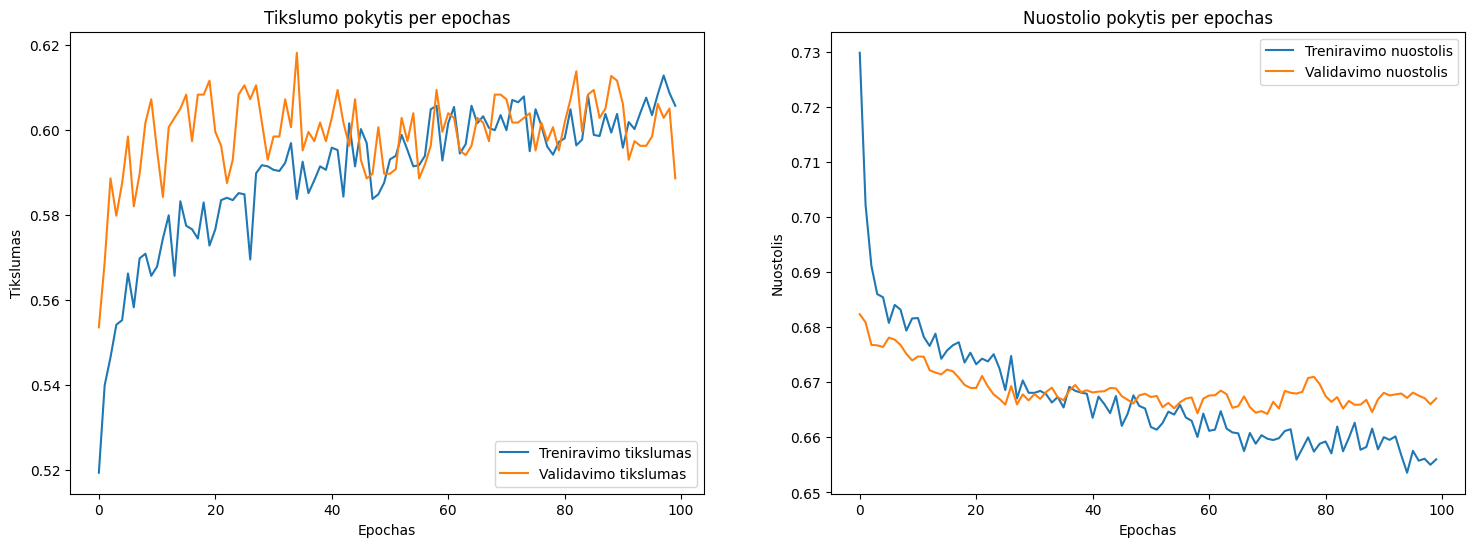

In [29]:
# Vizualizacija: tikslumo ir nuostolio pokytis
plt.figure(figsize=(18, 6))

# Tikslumo pokytis per epochas
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Treniravimo tikslumas")
plt.plot(history.history["val_accuracy"], label="Validavimo tikslumas")
plt.title("Tikslumo pokytis per epochas")
plt.xlabel("Epochas")
plt.ylabel("Tikslumas")
plt.legend()

# Nuostolio pokytis per epochas
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Treniravimo nuostolis")
plt.plot(history.history["val_loss"], label="Validavimo nuostolis")
plt.title("Nuostolio pokytis per epochas")
plt.xlabel("Epochas")
plt.ylabel("Nuostolis")
plt.legend()

plt.show()


Treniravimo ir validacijos tikslumai (~62%) rodo gerą modelio balansą be perviršio.

Kreivės stabilios po ~40 epochos.

Nuoseklus nuostolio mažėjimas abiejose kreivėse rodo tinkamą mokymąsi.

Modelis išmoksta stabiliai ir gerina rezultatus.
Tikslumas šiek tiek pagerėjo, lyginant su ankstesnėmis versijomis.